## Q.31. アフィン変換(スキュー)

(1)アフィン変換を用いて、出力(1)のようなX-sharing(dx = 30)画像を作成せよ。

(2)アフィン変換を用いて、出力2のようなY-sharing(dy = 30)画像を作成せよ。

(3)アフィン変換を用いて、出力3のような幾何変換した(dx = 30, dy = 30)画像を作成せよ。

このような画像はスキュー画像と呼ばれ、画像を斜め方向に伸ばした画像である。

出力(1)の場合、x方向にdxだけ引き伸ばした画像はX-sharingと呼ばれる。

出力(2)の場合、y方向にdyだけ引き伸ばした画像はY-sharingと呼ばれる。

それぞれ次式のアフィン変換で実現できる。
ただし、元画像のサイズがh x wとする。

```bash
(1) X-sharing                  (2) Y-sharing
   a = dx / h                     a = dy / w

  x'       1 a tx    x           x'       1 0 tx    x
[ y' ] = [ 0 1 ty ][ y ]       [ y' ] = [ a 1 ty ][ y ]
  1        0 0  1    1           1        0 0  1    1
```

|入力 (imori.jpg)|出力 (1) (answers_image/answer_31_1.jpg)|出力 (2) (answers_image/answer_31_2.jpg)|出力 (3) (answers_image/answer_31_3.jpg)|
|:---:|:---:|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_31_1.jpg)|![](answers_image/answer_31_2.jpg)|![](answers_image/answer_31_3.jpg)|

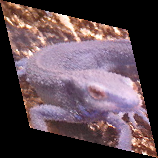

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Read image
_img = cv2.imread("./imori.jpg").astype(np.float32)
H, W, C = _img.shape


# Affine
dx = 30.
dy = 30.
a = 1.
b = dx / H
c = dy / W
d = 1.
tx = 0.
ty = 0.

img = np.zeros((H+2, W+2, C), dtype=np.float32)
img[1:H+1, 1:W+1] = _img

H_new = np.ceil(dy + H).astype(int)
W_new = np.ceil(dx + W).astype(int)
out = np.zeros((H_new, W_new, C), dtype=np.float32)

x_new = np.tile(np.arange(W_new), (H_new, 1))
y_new = np.arange(H_new).repeat(W_new).reshape(H_new, -1)

adbc = a * d - b * c
x = np.round((d * x_new  - b * y_new) / adbc).astype(int) - tx + 1
y = np.round((-c * x_new + a * y_new) / adbc).astype(int) - ty + 1

x = np.minimum(np.maximum(x, 0), W+1).astype(int)
y = np.minimum(np.maximum(y, 0), H+1).astype(int)

out[y_new, x_new] = img[y, x]
out = out.astype(np.uint8)

display(Image.fromarray(out))

## Q.32. フーリエ変換

二次元離散フーリエ変換(DFT)を実装し、*imori.jpg*をグレースケール化したものの周波数のパワースペクトルを表示せよ。
また、逆二次元離散フーリエ変換(IDFT)で画像を復元せよ。

二次元離散フーリエ変換(DFT: Discrete Fourier Transformation)とはフーリエ変換の画像に対する処理方法である。

通常のフーリエ変換はアナログ信号や音声などの連続値かつ一次元を対象に周波数成分を求める計算処理である。

一方、ディジタル画像は[0,255]の離散値をとり、かつ画像はHxWの二次元表示であるので、二次元離散フーリエ変換が行われる。

二次元離散フーリエ変換(DFT)は次式で計算される。

<!--
```bash
K = 0:W, l = 0:H, 入力画像をI として
G(k,l) = Sum_{y=0:H-1, x=0:W-1} I(x,y) exp( -2pi * j * (kx/W + ly/H)) / sqrt(H * W)
```
-->

K = [0, W-1], l = [0, H-1], 入力画像を I として

<img src="assets/dft_equ.png" width="500">

ここでは画像をグレースケール化してから二次元離散フーリエ変換を行え。

パワースペクトルとは Gは複素数で表されるので、Gの絶対値を求めることである。
今回のみ画像表示の時はパワースペクトルは[0,255]にスケーリングせよ。

逆二次元離散フーリエ変換(IDFT: Inverse DFT)とは周波数成分Gから元の画像を復元する手法であり、次式で定義される。

<!--
```bash
x = 0:W, y = 0:H  として
I(x,y) = Sum_{l=0:H-1, k=0:W-1} G(k,l) exp( 2pi * j * (kx/W + ly/H)) / sqrt(H * W)
```
-->
x = [0, W-1], y = [0, H-1] として

<img src="assets/idft_equ.png" width="500" >

上が定義式ですがexp(j)は複素数の値をとってしまうので、実際にコードにするときはぜ下式のように絶対値を使います。

<img src="assets/idft_equ2.png" width="500" >

シンプルに全部for文で回すと128^4の計算になるので、時間がかかってしまいます。numpyをうまく活用すれば計算コストを減らすことができます。（解答は128^2まで減らしました。）

|入力 (imori.jpg) |出力 (answers_image/answer_32.jpg)|パワースペクトル (answers_image/answer_32_ps.py)
|:---:|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_32.jpg)|![](answers_image/answer_32_ps.jpg)|

(128, 128)


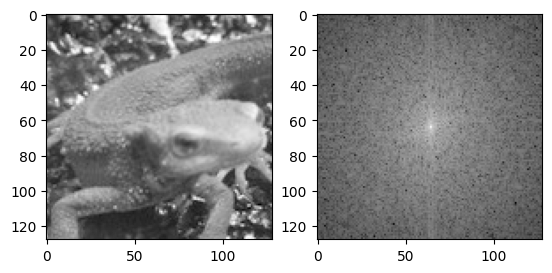

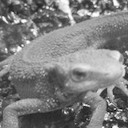

In [2]:
# Read image
img = cv2.imread("./imori.jpg").astype(np.float32)
H, W, C = img.shape

# Gray scale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]


f_img = np.fft.fft2(gray)
    
# Swap the first quadrant and the third quadrant, the second quadrant and the fourth quadrant
f_img =  np.fft.fftshift(f_img)
print(f_img.shape)
# Calculation of power spectrum 
mag = 20*np.log(np.abs(f_img))
    
# Show input image and spectrum image
plt.subplot(121)
plt.imshow(gray, cmap = 'gray')
plt.subplot(122)
plt.imshow(mag, cmap = 'gray')
plt.show()


# DFT
K = W
L = H
M = W
N = H

G = np.zeros((L, K), dtype=complex)

x = np.tile(np.arange(W), (H, 1))
y = np.arange(H).repeat(W).reshape(H, -1)

for l in range(L):
    for k in range(K):
        G[l, k] = np.sum(gray * np.exp(-2j * np.pi * (x * k / M + y * l / N))) / np.sqrt(M * N)
        #for n in range(N):
        #    for m in range(M):
        #        v += gray[n, m] * np.exp(-2j * np.pi * (m * k / M + n * l / N))
        #G[l, k] = v / np.sqrt(M * N)

ps = (np.abs(G) / np.abs(G).max() * 255).astype(np.uint8)
cv2.imwrite("out_ps.jpg", ps)

# IDFT
out = np.zeros((H, W), dtype=np.float32)

for n in range(N):
    for m in range(M):
        out[n,m] = np.abs(np.sum(G * np.exp(2j * np.pi * (x * m / M + y * n / N)))) / np.sqrt(M * N)

out[out>255] = 255
out = out.astype(np.uint8)

display(Image.fromarray(out))

## Q.33. フーリエ変換　ローパスフィルタ

*imori.jpg*をグレースケール化したものをDFTし、ローパスフィルタを通してIDFTで画像を復元せよ。

DFTによって得られた周波数成分は左上、右上、左下、右下に近いほど低周波数の成分を含んでいることになり、中心に近いほど高周波成分を示す。

![](assets/lpf.png)

画像における高周波成分とは色が変わっている部分（ノイズや輪郭など）を示し、低周波成分とは色があまり変わっていない部分（夕日のグラデーションなど）を表す。
ここでは、高周波成分をカットし、低周波成分のみを通す**ローパスフィルタ**を実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.5rまでの成分を通すとする。

|入力 (imori.jpg)|出力 (answers_image/answer_33.jpg)|
|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_33.jpg)|

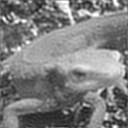

In [3]:
# Read image
img = cv2.imread("./imori.jpg").astype(np.float32)
H, W, C = img.shape

# Gray scale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# DFT
K = W
L = H
M = W
N = H

G = np.zeros((L, K), dtype=complex)

x = np.tile(np.arange(W), (H, 1))
y = np.arange(H).repeat(W).reshape(H, -1)

for l in range(L):
    for k in range(K):
        G[l, k] = np.sum(gray * np.exp(-2j * np.pi *
                                       (x * k / M + y * l / N))) / np.sqrt(M * N)

# Low-pass filter
_G = np.zeros_like(G)
_G[:H//2, :W//2] = G[H//2:, W//2:]
_G[:H//2, W//2:] = G[H//2:, :W//2]
_G[H//2:, :W//2] = G[:H//2, W//2:]
_G[H//2:, W//2:] = G[:H//2, :W//2]
p = 0.5
_x = x - W // 2
_y = y - H // 2
r = np.sqrt(_x ** 2 + _y ** 2)
mask = np.ones((H, W), dtype=np.float32)
mask[r > (W//2*p)] = 0

_G *= mask

G[:H//2, :W//2] = _G[H//2:, W//2:]
G[:H//2, W//2:] = _G[H//2:, :W//2]
G[H//2:, :W//2] = _G[:H//2, W//2:]
G[H//2:, W//2:] = _G[:H//2, :W//2]

# IDFT
out = np.zeros((H, W), dtype=np.float32)

for n in range(N):
    for m in range(M):
        out[n, m] = np.abs(
            np.sum(G * np.exp(2j * np.pi * (x * m / M + y * n / N)))) / np.sqrt(M * N)

out[out > 255] = 255
out = out.astype(np.uint8)

display(Image.fromarray(out))

## Q.34. フーリエ変換　ハイパスフィルタ

*imori.jpg*をグレースケール化したものをDFTし、ハイパスフィルタを通してIDFTで画像を復元せよ。

ここでは、低周波成分をカットし、高周波成分のみを通す**ハイパスフィルタ**を実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.1rからの成分を通すとする。

|入力 (imori.jpg)|出力 (answers_image/answer_34.jpg)|
|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_34.jpg)|

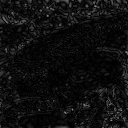

In [4]:
# Read image
img = cv2.imread("./imori.jpg").astype(np.float32)
H, W, C = img.shape

# Gray scale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# DFT
K = W
L = H   
M = W
N = H

G = np.zeros((L, K), dtype=complex)

x = np.tile(np.arange(W), (H, 1))
y = np.arange(H).repeat(W).reshape(H, -1)

for l in range(L):
    for k in range(K):
        G[l, k] = np.sum(gray * np.exp(-2j * np.pi *
                                       (x * k / M + y * l / N))) / np.sqrt(M * N)

# High-pass filter
_G = np.zeros_like(G)
_G[: H // 2, : W // 2] = G[H // 2 :, W // 2 :]
_G[: H // 2, W // 2 :] = G[H // 2 :, : W // 2]
_G[H // 2:, : W // 2] = G[: H // 2, W // 2:]
_G[H // 2:, W // 2:] = G[: H // 2, : W // 2]

p = 0.2
_x = x - W // 2
_y = y - H // 2
r = np.sqrt(_x ** 2 + _y ** 2)
mask = np.ones((H, W), dtype=np.float32)
mask[r < (W//2*p)] = 0

_G *= mask

G[:H//2, :W//2] = _G[H//2:, W//2:]
G[:H//2, W//2:] = _G[H//2:, :W//2]
G[H//2:, :W//2] = _G[:H//2, W//2:]
G[H//2:, W//2:] = _G[:H//2, :W//2]

# IDFT
out = np.zeros((H, W), dtype=np.float32)

for n in range(N):
    for m in range(M):
        out[n, m] = np.abs(
            np.sum(G * np.exp(2j * np.pi * (x * m / M + y * n / N)))) / np.sqrt(M * N)

out[out > 255] = 255
out = out.astype(np.uint8)

display(Image.fromarray(out))

## Q.35. フーリエ変換　バンドパスフィルタ

*imori.jpg*をグレースケール化したものをDFTし、ハイパスフィルタを通してIDFTで画像を復元せよ。

ここでは、低周波成分と高周波成分の中間の周波数成分のみを通す**ハイパスフィルタ**を実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.1rから0.5rまでの成分を通すとする。

|入力 (imori.jpg)|出力 (answers_image/answer_35.jpg)|
|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_35.jpg)|

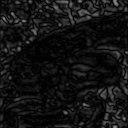

In [5]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# Gray scale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# DFT
K = W
L = H
M = W
N = H

G = np.zeros((L, K), dtype=complex)

x = np.tile(np.arange(W), (H, 1))
y = np.arange(H).repeat(W).reshape(H, -1)

for l in range(L):
    for k in range(K):
        G[l, k] = np.sum(gray * np.exp(-2j * np.pi *
                                       (x * k / M + y * l / N))) / np.sqrt(M * N)

# Band-pass filter
_G = np.zeros_like(G)
_G[:H//2, :W//2] = G[H//2:, W//2:]
_G[:H//2, W//2:] = G[H//2:, :W//2]
_G[H//2:, :W//2] = G[:H//2, W//2:]
_G[H//2:, W//2:] = G[:H//2, :W//2]
p1 = 0.1
p2 = 0.5
_x = x - W // 2
_y = y - H // 2
r = np.sqrt(_x ** 2 + _y ** 2)
mask = np.zeros((H, W), dtype=np.float32)
mask[np.where((r > (W//2*p1)) & (r < (W//2*p2)))] = 1

_G *= mask

G[:H//2, :W//2] = _G[H//2:, W//2:]
G[:H//2, W//2:] = _G[H//2:, :W//2]
G[H//2:, :W//2] = _G[:H//2, W//2:]
G[H//2:, W//2:] = _G[:H//2, :W//2]

# IDFT
out = np.zeros((H, W), dtype=np.float32)

for n in range(N):
    for m in range(M):
        out[n, m] = np.abs(
            np.sum(G * np.exp(2j * np.pi * (x * m / M + y * n / N)))) / np.sqrt(M * N)

out[out > 255] = 255
out = out.astype(np.uint8)

display(Image.fromarray(out))

## Q.36. JPEG圧縮 (Step.1)離散コサイン変換

*imori.jpg*をグレースケール化し離散コサイン変換を行い、逆離散コサイン変換を行え。

離散コサイン変換(DCT: Discrete Cosine Transformation)とは、次式で定義される周波数変換の一つである。

<img src="assets/dct_equ.png" width="600" >

<!--
```bash
T = 8
F(u,v) = 2 / T * C(u)C(v) * Sum_{y=0:T-1} Sum_{x=0:T-1} f(x,y) cos((2x+1)u*pi/2T) cos((2y+1)v*pi/2T)
```
-->

逆離散コサイン変換(IDCT: Inverse Discrete Cosine Transformation)とは離散コサイン変換の逆（復号）であり、次式で定義される。
ここでいう K は復元時にどれだけ解像度を良くするかを決定するパラメータである。
K = Tの時は、DCT係数を全部使うのでIDCT後の解像度は最大になるが、Kが１や２などの時は復元に使う情報量（DCT係数）が減るので解像度が下がる。これを適度に設定することで、画像の容量を減らすことができる。

<img src="assets/idct_equ.png" width="600">

<!--
```bash
T = 8
K = 8
f(x,y) = 2 / T * C(x)C(y) * Sum_{u=0:K-1} Sum_{v=0:K-1} F(u,v) cos((2x+1)u*pi/2T) cos((2y+1)v*pi/2T)
```
-->

ここでは画像を8x8ずつの領域に分割して、各領域で以上のDCT, IDCTを繰り返すことで、jpeg符号に応用される。
今回も同様に8x8の領域に分割して、DCT, IDCTを行え。

|入力 (imori.jpg)|出力 (answers_image/answer_36.jpg)|
|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_36.jpg)|

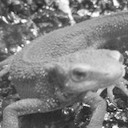

In [6]:
# Read image
img = cv2.imread("./imori.jpg").astype(np.float32)
H, W, C = img.shape

# Gray scale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# DCT
T = 8
K = 8
X = np.zeros((H, W), dtype=np.float32)

#ind_x = np.tile(np.arange(T), (T, 1))
#ind_y = np.arange(T).repeat(T).reshape(T, -1)
#dct = np.ones_like(ind_x, dtype=np.float32)
#dct[:, 0] /= np.sqrt(2)
#dct[0] /= np.sqrt(2)


def w(x, y, u, v):
    cu = 1.
    cv = 1.
    if u == 0:
        cu /= np.sqrt(2)
    if v == 0:
        cv /= np.sqrt(2)
    theta = np.pi / (2 * T)
    return ((2 * cu * cv / T) * np.cos((2*x+1)*u*theta) * np.cos((2*y+1)*v*theta))


for yi in range(0, H, T):
    for xi in range(0, W, T):
        for v in range(T):
            for u in range(T):
                for y in range(T):
                    for x in range(T):
                        X[v+yi, u+xi] += gray[y+yi, x+xi] * w(x, y, u, v)
                """
                _x = ind_x + xi * T
                _y = ind_y + yi * T
                _u = u + xi * T
                _v = v + yi * T
                X[_v, _u] = np.sum(C * gray[_y, _x] * np.cos((2*ind_x+1)*u*np.pi/(2*T)) * np.cos((2*indy+1)*v*np.pi/(2*T)))
                """

# IDCT
out = np.zeros((H, W), dtype=np.float32)

for yi in range(0, H, T):
    for xi in range(0, W, T):
        for y in range(T):
            for x in range(T):
                for v in range(K):
                    for u in range(K):
                        out[y+yi, x+xi] += X[v+yi, u+xi] * w(x, y, u, v)
                """
                _u = ind_x + xi * T
                _v = ind_y + yi * T
                _x = x + yi * T
                _y = y + xi * T
                out[_y, _x] = np.sum(C * X[_v, _u] * np.cos((2*x+1)*ind_x*np.pi/(2*T)) * np.cos((2*y+1)*indy*np.pi/(2*T))) * 4. / (T ** 2)
                """
out[out > 255] = 255
out = np.round(out).astype(np.uint8)

display(Image.fromarray(out))

## Q.37. PSNR

IDCTで用いるDCT係数を8でなく、4にすると画像の劣化が生じる。
入力画像とIDCT画像のPSNRを求めよ。また、IDCTによるビットレートを求めよ。

PSNR(Peak Signal to Noise Ratio)とは信号対雑音比と呼ばれ、画像がどれだけ劣化したかを示す。

PSNRが大きいほど、画像が劣化していないことを示し、次式で定義される。
MAXは取りうる値の最大値で[0,255]の表示なら MAX=255　となる。
また、MSEはMean Squared Error(平均二乗誤差)と呼ばれ、二つの画像の差分の二乗の平均値を示す。

<img src="assets/psnr_mse_equ.png" width="500">

<!--
```bash
PSNR = 10 * log10(MAX^2 / MSE)
MSE = Sum_{y=0:H-1} Sum_{x=0:W-1} (I1(x,y) - I2(x,y))^2 / (HW)
```
-->

ビットレートとは8x8でDCTを行い、IDCTでKxKの係数までを用いた時に次式で定義される。

```bash
bitrate = 8 * K^2 / 8^2
```

|入力 (imori.jpg)|出力 (answers_image/answer_37.jpg) (PSNR = 27.62, Bitrate=2.0)|
|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_37.jpg)|

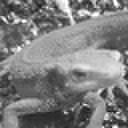

PSNR >> 27.61714124916368
bitrate >> 2.0


In [7]:
# Read image
img = cv2.imread("./imori.jpg").astype(np.float32)
H, W, C = img.shape

# Gray scale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# DCT
T = 8
K = 4
X = np.zeros((H, W), dtype=np.float64)


def w(x, y, u, v):
    cu = 1.
    cv = 1.
    if u == 0:
        cu /= np.sqrt(2)
    if v == 0:
        cv /= np.sqrt(2)
    theta = np.pi / (2 * T)
    return ((2 * cu * cv / T) * np.cos((2*x+1)*u*theta) * np.cos((2*y+1)*v*theta))


for yi in range(0, H, T):
    for xi in range(0, W, T):
        for v in range(T):
            for u in range(T):
                for y in range(T):
                    for x in range(T):
                        X[v+yi, u+xi] += gray[y+yi, x+xi] * w(x, y, u, v)

# IDCT
out = np.zeros((H, W), dtype=np.float64)

for yi in range(0, H, T):
    for xi in range(0, W, T):
        for y in range(T):
            for x in range(T):
                for v in range(K):
                    for u in range(K):
                        out[y+yi, x+xi] += X[v+yi, u+xi] * w(x, y, u, v)

out[out > 255] = 255
out = np.floor(out).astype(np.uint8)

display(Image.fromarray(out))

# MSE
v_max = 255.
mse = np.sum(np.power(np.abs(gray.astype(np.float32) -
                             out.astype(np.float32)), 2)) / (H * W)
psnr = 10 * np.log10(v_max ** 2 / mse)

print("PSNR >>", psnr)

bitrate = 1. * T * K ** 2 / (T ** 2)
print("bitrate >>", bitrate)

## Q.38. JPEG圧縮 (Step.2)DCT+量子化

DCT係数を量子化し、IDCTで復元せよ。また、その時の画像の容量を比べよ。

DCT係数を量子化することはjpeg画像にする符号化で用いられる手法である。

量子化とは、値を予め決定された区分毎に値を大まかに丸め込む作業であり、floorやceil, roundなどが似た計算である。

JPEG画像ではDCT係数を下記で表される量子化テーブルに則って量子化する。
この量子化テーブルはjpeg団体の仕様書から取った。
量子化では8x8の係数をQで割り、四捨五入する。その後Qを掛けることで行われる。
IDCTでは係数は全て用いるものとする。

```bash
Q = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
              (12, 12, 14, 19, 26, 58, 60, 55),
              (14, 13, 16, 24, 40, 57, 69, 56),
              (14, 17, 22, 29, 51, 87, 80, 62),
              (18, 22, 37, 56, 68, 109, 103, 77),
              (24, 35, 55, 64, 81, 104, 113, 92),
              (49, 64, 78, 87, 103, 121, 120, 101),
              (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)
```

量子化を行うと画像の容量が減っていることから、データ量が削減されたことが伺える。

|入力 (imori.jpg)|出力 (answers_image/answer_38.jpg) (7kb)|
|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_38.jpg)|

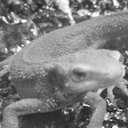

PSNR >> 30.54433321359918
bitrate >> 8.0


In [8]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# Gray scale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# DCT
T = 8
K = 8
X = np.zeros((H, W), dtype=np.float64)

Q = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
              (12, 12, 14, 19, 26, 58, 60, 55),
              (14, 13, 16, 24, 40, 57, 69, 56),
              (14, 17, 22, 29, 51, 87, 80, 62),
              (18, 22, 37, 56, 68, 109, 103, 77),
              (24, 35, 55, 64, 81, 104, 113, 92),
              (49, 64, 78, 87, 103, 121, 120, 101),
              (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)


def w(x, y, u, v):
    cu = 1.
    cv = 1.
    if u == 0:
        cu /= np.sqrt(2)
    if v == 0:
        cv /= np.sqrt(2)
    theta = np.pi / (2 * T)
    return ((2 * cu * cv / T) * np.cos((2*x+1)*u*theta) * np.cos((2*y+1)*v*theta))


for yi in range(0, H, T):
    for xi in range(0, W, T):
        for v in range(T):
            for u in range(T):
                for y in range(T):
                    for x in range(T):
                        X[v+yi, u+xi] += gray[y+yi, x+xi] * w(x, y, u, v)
        X[yi:yi+T, xi:xi+T] = np.round(X[yi:yi+T, xi:xi+T] / Q) * Q

# IDCT
out = np.zeros((H, W), dtype=np.float64)

for yi in range(0, H, T):
    for xi in range(0, W, T):
        for y in range(T):
            for x in range(T):
                for v in range(K):
                    for u in range(K):
                        out[y+yi, x+xi] += X[v+yi, u+xi] * w(x, y, u, v)

                        
out[out > 255] = 255
out = np.floor(out).astype(np.uint8)

display(Image.fromarray(out))

# MSE
v_max = 255.
mse = np.sum(np.power(np.abs(gray.astype(np.float32) -
                             out.astype(np.float32)), 2)) / (H * W)
psnr = 10 * np.log10(v_max ** 2 / mse)

print("PSNR >>", psnr)

bitrate = 1. * T * K ** 2 / (T ** 2)
print("bitrate >>", bitrate)

## Q.39. JPEG圧縮 (Step.3)YCbCr表色系

YCbCr表色形において、Yを0.7倍してコントラストを暗くせよ。

YCbCr表色系とは、画像を明るさを表すY、輝度と青レベルの差Cb、輝度と赤レベルの差Crに分解する表現方法である。

これはJPEG変換で用いられる。

RGBからYCbCrへの変換は次式。

```bash
Y = 0.299 * R + 0.5870 * G + 0.114 * B
Cb = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
Cr = 0.5 * R - 0.4187 * G - 0.0813 * B + 128
```

YCbCrからRGBへの変換は次式。

```bash
R = Y + (Cr - 128) * 1.402
G = Y - (Cb - 128) * 0.3441 - (Cr - 128) * 0.7139
B = Y + (Cb - 128) * 1.7718
```

|入力 (imori.jpg)|出力 (answers_image/answer_39.jpg) |
|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_39.jpg)|

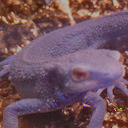

In [9]:
# Read image
img = cv2.imread("./imori.jpg").astype(np.float32)
H, W, C = img.shape

# RGB > YCbCr
Y = 0.2990 * img[..., 2] + 0.5870 * img[..., 1] + 0.1140 * img[..., 0]
Cb = -0.1687 * img[..., 2] - 0.3313 * img[..., 1] + 0.5 * img[..., 0] + 128.
Cr = 0.5 * img[..., 2] - 0.4187 * img[..., 1] - 0.0813 * img[..., 0] + 128.

Y *= 0.7

# YCbCr > RGB
out = np.zeros_like(img, dtype=np.float32)
out[..., 2] = Y + (Cr - 128.) * 1.4020
out[..., 1] = Y - (Cb - 128.) * 0.3441 - (Cr - 128.) * 0.7139
out[..., 0] = Y + (Cb - 128.) * 1.7718

out = out.astype(np.uint8)

display(Image.fromarray(out))

## Q.40. JPEG圧縮 (Step.4)YCbCr+DCT+量子化

YCbCr表色系にし、DCT後、Yを量子化テーブルQ1、CbとCrをQ2で量子化し、IDCTで画像を復元せよ。
また、画像の容量を比較せよ。

アルゴリズムは、
1. RGB を YCbCrに変換
2. YCbCrをDCT
3. DCTしたものを量子化
4. 量子化したものをIDCT
5. IDCTしたYCbCrをRGBに変換

これはJPEGで実際に使われるデータ量削減の手法であり、Q1,Q2はJPEGの仕様書に則って次式で定義される。

```bash
Q1 = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
               (12, 12, 14, 19, 26, 58, 60, 55),
               (14, 13, 16, 24, 40, 57, 69, 56),
               (14, 17, 22, 29, 51, 87, 80, 62),
               (18, 22, 37, 56, 68, 109, 103, 77),
               (24, 35, 55, 64, 81, 104, 113, 92),
               (49, 64, 78, 87, 103, 121, 120, 101),
               (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)

Q2 = np.array(((17, 18, 24, 47, 99, 99, 99, 99),
               (18, 21, 26, 66, 99, 99, 99, 99),
               (24, 26, 56, 99, 99, 99, 99, 99),
               (47, 66, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99)), dtype=np.float32)
```

|入力 (imori.jpg) (13kb)|出力 (answers_image/answer_40.jpg) (9kb)|
|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_40.jpg)|

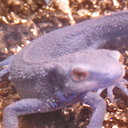

PSNR >> 29.41777189290776
bitrate >> 8.0


In [10]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# RGB > YCbCr
Y = 0.2990 * img[..., 2] + 0.5870 * img[..., 1] + 0.1140 * img[..., 0]
Cb = -0.1687 * img[..., 2] - 0.3313 * img[..., 1] + 0.5 * img[..., 0] + 128.
Cr = 0.5 * img[..., 2] - 0.4187 * img[..., 1] - 0.0813 * img[..., 0] + 128.

YCC = np.zeros_like(img, dtype=np.float32)
YCC[..., 0] = Y
YCC[..., 1] = Cb
YCC[..., 2] = Cr


# DCT
T = 8
K = 8
X = np.zeros((H, W, C), dtype=np.float64)

Q1 = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
               (12, 12, 14, 19, 26, 58, 60, 55),
               (14, 13, 16, 24, 40, 57, 69, 56),
               (14, 17, 22, 29, 51, 87, 80, 62),
               (18, 22, 37, 56, 68, 109, 103, 77),
               (24, 35, 55, 64, 81, 104, 113, 92),
               (49, 64, 78, 87, 103, 121, 120, 101),
               (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)

Q2 = np.array(((17, 18, 24, 47, 99, 99, 99, 99),
               (18, 21, 26, 66, 99, 99, 99, 99),
               (24, 26, 56, 99, 99, 99, 99, 99),
               (47, 66, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99)), dtype=np.float32)


def w(x, y, u, v):
    cu = 1.
    cv = 1.
    if u == 0:
        cu /= np.sqrt(2)
    if v == 0:
        cv /= np.sqrt(2)
    theta = np.pi / (2 * T)
    return ((2 * cu * cv / T) * np.cos((2*x+1)*u*theta) * np.cos((2*y+1)*v*theta))


for yi in range(0, H, T):
    for xi in range(0, W, T):
        for v in range(T):
            for u in range(T):
                for y in range(T):
                    for x in range(T):
                        for c in range(C):
                            X[v+yi, u+xi, c] += YCC[y+yi,
                                                    x+xi, c] * w(x, y, u, v)

        X[yi:yi+T, xi:xi+T, 0] = np.round(X[yi:yi+T, xi:xi+T, 0] / Q1) * Q1
        X[yi:yi+T, xi:xi+T, 1] = np.round(X[yi:yi+T, xi:xi+T, 1] / Q2) * Q2
        X[yi:yi+T, xi:xi+T, 2] = np.round(X[yi:yi+T, xi:xi+T, 2] / Q2) * Q2


# IDCT
IYCC = np.zeros((H, W, 3), dtype=np.float64)

for yi in range(0, H, T):
    for xi in range(0, W, T):
        for y in range(T):
            for x in range(T):
                for v in range(K):
                    for u in range(K):
                        IYCC[y+yi, x+xi] += X[v+yi, u+xi] * w(x, y, u, v)


# YCbCr > RGB
out = np.zeros_like(img, dtype=np.float32)
out[..., 2] = IYCC[..., 0] + (IYCC[..., 2] - 128.) * 1.4020
out[..., 1] = IYCC[..., 0] - (IYCC[..., 1] - 128.) * \
    0.3441 - (IYCC[..., 2] - 128.) * 0.7139
out[..., 0] = IYCC[..., 0] + (IYCC[..., 1] - 128.) * 1.7718

out[out > 255] = 255
out = out.astype(np.uint8)

display(Image.fromarray(out))

# MSE
v_max = 255.
mse = np.sum(np.power(np.abs(img.astype(np.float32) -
                             out.astype(np.float32)), 2)) / (H * W * C)
psnr = 10 * np.log10(v_max ** 2 / mse)

print("PSNR >>", psnr)

bitrate = 1. * T * K ** 2 / (T ** 2)
print("bitrate >>", bitrate)